In [33]:
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from skfeature.function.similarity_based import fisher_score

from ruletransform import ContractedRuleTransform
from ruletransform.utils import get_shapelets_lengths_interval, get_indices
from ruletransform.data_io import load_from_tsfile_to_dataframe

# Load Dataset

In [35]:
name = 'BasicMotions'

X_train, y_train = load_from_tsfile_to_dataframe(
    os.path.abspath(os.path.join('..', 'data', name, name + "_TRAIN.ts"))
)
X_test, y_test = load_from_tsfile_to_dataframe(
        os.path.abspath(os.path.join('..', 'data', name, name + "_TEST.ts"))
    )

# Shapelet Length Selection

In [36]:
min_length, max_length = get_shapelets_lengths_interval(X_train, y_train, total_time=2)

# Rule Transform Without Shapelet Clustering

## Fit and Transform Dataset

In [37]:
rt = ContractedRuleTransform(
    shapelet_mining_contract=2,
    rule_mining_contract=1,
    min_shapelet_length=min_length,
    max_shapelet_length=max_length,
    verbose=0,
)

#Given the short mining contract, this example only uses the first two dimensions of the dataset
rt.fit(X_train.iloc[:, 0:2], y_train)
all_rules_counts = rt.transform(X_train.iloc[:, 0:2], test=False)
all_rules_counts_test = rt.transform(X_test.iloc[:, 0:2], test=True)

## Rule Visualization

In [38]:
indices = get_indices(rt._transformer)

In [39]:
dim_1, sh_1, dim_2, sh_2 = 0, 0, 1, 20
idx_1, start_1, end_1 = indices[dim_1][sh_1]
idx_2, start_2, end_2 = indices[dim_2][sh_2]

In [40]:
from ruletransform.sktime_convert import from_nested_to_3d_numpy
from matplotlib import pyplot as plt

X_train_ = from_nested_to_3d_numpy(X_train)

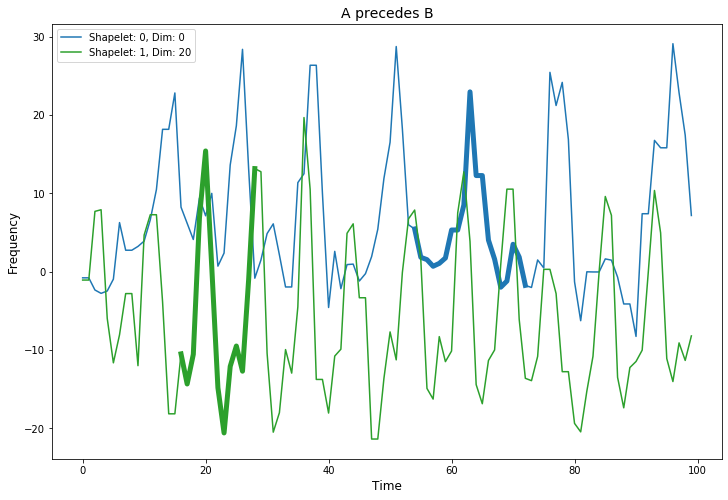

In [41]:
plt.figure(figsize=(12,8))


plt.plot(X_train_[idx_1,dim_1], color='C{}'.format(0),
          label='Shapelet: ' + str(dim_1) + ', Dim: ' + str(sh_1))
plt.plot(np.arange(start_1, end_1), X_train_[idx_1, dim_1, start_1:end_1],
          lw=5, color='C{}'.format(0))

plt.plot(X_train_[idx_2,dim_2], color='C{}'.format(2),
          label='Shapelet: ' + str(dim_2) + ', Dim: ' + str(sh_2))
plt.plot(np.arange(start_2, end_2), X_train_[idx_2, dim_2, start_2:end_2],
          lw=5, color='C{}'.format(2))

plt.xlabel('Time', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title("A precedes B", fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.show()

## Rule Selection

In [42]:
#Percentage of rules to keep
percentage = 20

top_k = int(all_rules_counts.shape[1]*percentage/100)

In [43]:
#Indices of rules between inexistant shapelets (flagged -1 supports)
to_delete = np.where(np.all(all_rules_counts==-1,axis=1))

#Delete the -1 columns
all_rules_counts = np.delete(all_rules_counts, to_delete, axis=0)
all_rules_counts_test = np.delete(all_rules_counts_test, to_delete, axis=0)

 #Array to hold the support of each rule
supports = np.zeros(all_rules_counts.shape[1], dtype=np.uint16)

#Count and store the support of each rule
for k in range(all_rules_counts.shape[1]):
    supports[k]=all_rules_counts[:,k].sum()

#Get indices of rules with highest support
best_rules_indices = np.argsort(supports)[::-1][:top_k]

#Get the best rules
best_rules = all_rules_counts[:,best_rules_indices]
best_rules_test = all_rules_counts_test[:,best_rules_indices] 

## Classification

In [44]:
#Fit and Transform a Random Forest Classifier
clf = RandomForestClassifier(random_state=0, n_estimators=500)
clf.fit(best_rules, y_train)
y_pred = clf.predict(best_rules_test)

In [45]:
#Compute Test Accuracy
print('The test accuracy is: ' + str(accuracy_score(y_test, y_pred)))

The test accuracy is: 0.975


# Rule Transform With Shapelet Clustering

## Fit and Transform Dataset

In [46]:
rt = ContractedRuleTransform(
    shapelet_mining_contract=2,
    rule_mining_contract=1,
    min_shapelet_length=min_length,
    max_shapelet_length=max_length,
    verbose=0,
    clustering_ratio=80
)

rt.fit(X_train.iloc[:, 0:2], y_train)
all_rules_counts = rt.transform(X_train.iloc[:, 0:2], test=False)
all_rules_counts_test = rt.transform(X_test.iloc[:, 0:2], test=True)

## Classification

In [47]:
#Fit and Transform a Random Forest Classifier
clf = RandomForestClassifier(random_state=0, n_estimators=500)
clf.fit(all_rules_counts, y_train)
y_pred = clf.predict(all_rules_counts_test)

#Compute Test Accuracy
print('The test accuracy is: ' + str(accuracy_score(y_test, y_pred)))

The test accuracy is: 0.925
